In [1]:
import matplotlib.pyplot as plt
import numpy as np
import diagnostics as diag
import numpy.ma as ma

In [2]:
exp = diag.plume('../../data/Nyles/plume_2days_pressure/', 'plume_2days_pressure')

In [3]:
exp.params['global_shape']

(174, 32, 64, 64)

# Defining control volume

The first part of the experiment consisted in defining a control volume large enough to include the whole plume dynamics, but not so large to avoid including the sponge layers at the boundaries of the domain. We decided the control volume to be a cylinder because it matches the symmetry that the plume has with the $z$-axis. To define the radius and the height of the control volume we computed the horizontal mass flux through the lateral sides of the cylinder and the vertical mass flux through the top 'lid' of the cylinder, to see at which values there wasn't large peaks in mass flux due to the proximity of the plume.

## Momentum flux criterion

As in gao2019convective we define the height of our cylinder as the level where the magnitude of the area-averaged vertical momentum flux is 10% of the maximum of all the levels of vertical momentum flux. 

In [4]:
len(exp.time)

174

In [6]:
M_flux_lvl = exp.Flux_levels('momentum', r_lim=0.3)
z = exp.read_vars('z')['z']
plume_height = np.zeros(len(exp.time))
for t in range(len(exp.time)):
    idx = diag.find_z_plume(M_flux_lvl[t], 0.1)
    plume_height[t] = z[idx]
    
z_mean = (plume_height/2000).mean()

In [7]:
variables = exp.read_vars(['x', 'y', 'w'])

x = variables['x']
#y = variables['y']

XZ, ZX = np.meshgrid(x/exp.params['Lx']-0.5, z/exp.params['Lz'])
#XY, YX = np.meshgrid(x/exp.params['Lx']-0.5, y/exp.params['Ly'])

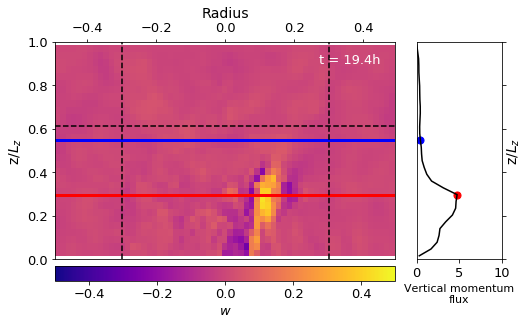

In [8]:
n = 70
maxx = 0.5
minn = -0.5
Lz = 2000

field = variables['w']#/62.5
z_plume_idx = diag.find_z_plume(M_flux_lvl[n], 0.1)
M_max_idx = diag.find_z_plume(M_flux_lvl[n], 1) 

plt.rcParams.update({'font.size': 13})
fig, (ax1, ax2) = plt.subplots(ncols=2, 
                             gridspec_kw = {'width_ratios':[4, 1], 'wspace': 0.1}, 
                             sharey=True)
fig.set_size_inches(8,4)

im1 = ax1.pcolormesh(XZ, ZX, field[n, :, 32, :], cmap='plasma',
                    vmin=minn, vmax=maxx)
ax1.axhline(z[z_plume_idx]/Lz, c='blue', lw=3)
ax1.axhline(z[M_max_idx]/Lz, c='red', lw=3)
ax1.axvline(0.3, c='k', linestyle='--')
ax1.axvline(-0.3, c='k', linestyle='--')
ax1.axhline(z_mean, c='k', linestyle='--')
ax1.set_xlabel('Radius', fontsize=14)
ax1.set_ylabel('z/$L_z$', fontsize=14)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.text(0.27, 0.9, f't = {exp.time[n]/3600:0.1f}h', color='w')

ax2.plot(M_flux_lvl[n], z/Lz, c='k')
ax2.scatter(M_flux_lvl[n, z_plume_idx], z[z_plume_idx]/Lz, c='blue', s=50)
ax2.scatter(M_flux_lvl[n, M_max_idx], z[M_max_idx]/Lz, c='red', s=50)
ax2.yaxis.tick_right()
ax2.set_ylim(0,1)
ax2.set_xlim(0,10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel('Vertical momentum\nflux', fontsize=11) #'$\mathscr{P}$'
ax2.set_ylabel('z/$L_z$', fontsize=14)

p0 = ax1.get_position().get_points().flatten()
p2 = ax2.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.05, p0[2] - p0[0], 0.05])
cbar = plt.colorbar(im1, cax=ax_cbar, orientation='horizontal')
cbar.set_label('$w$')

Text(0.5, 0, 'time (hours)')

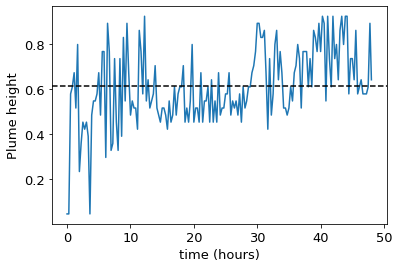

In [12]:
z_mean = (plume_height/2000).mean()
plt.plot(exp.time/3600, plume_height/2000)
plt.axhline(y=z_mean, color='k', ls='--')
plt.ylabel('Plume height')
plt.xlabel('time (hours)')

## checking mass flux
The first part of the experiment consisted in defining a control volume large enough to include the whole plume dynamics, but not so large to avoid including the sponge layers at the boundaries of the domain. We decided the control volume to be a cylinder because it matches the symmetry that the plume has with the $z$-axis. To define the radius and the height of the control volume we computed the horizontal mass flux through the lateral sides of the cylinder and the vertical mass flux through the top 'lid' of the cylinder, to see at which values there wasn't large peaks in mass flux due to the proximity of the plume.

Text(0, 0.5, 'STD of vertical flux')

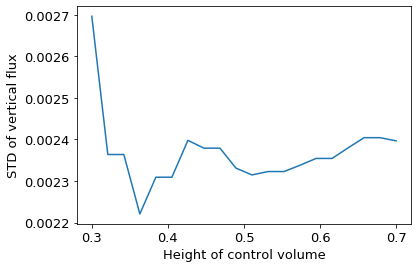

In [13]:
z_range = np.linspace(0.3,0.7, 20)
std_vert = []
mean_vert = []
for zi in z_range:
    vert_mass_flux = exp.Lid_flux('none', r_lim=0.3, z_lim=zi)
    std_vert.append(np.std(vert_mass_flux))
    mean_vert.append(np.mean(vert_mass_flux))
                     
plt.plot(z_range, std_vert)
plt.xlabel('Height of control volume')
plt.ylabel('STD of vertical flux')

Text(0, 0.5, 'STD of lateral flux')

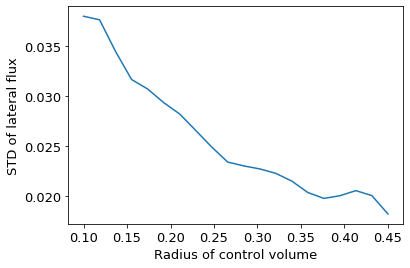

In [14]:
r_range = np.linspace(0.1,0.45, 20)
std_lat = []
for ri in r_range:
    lat_mass_flux = exp.Lateral_flux('none', r_lim=ri, z_lim=0.6)
    std_lat.append(np.std(lat_mass_flux))
    
plt.plot(r_range, std_lat)
plt.xlabel('Radius of control volume')
plt.ylabel('STD of lateral flux')

We selected this parameters to be $r_{lim} = 0.3$ and $z_{lim} = 0.55$.

In [16]:
r_lim = 0.3
z_lim = 0.6

# Defining the ring for surface flux

We used edge detection algorithm to great the mask 

In [14]:
x = exp.read_vars(['x'])['x']
y = exp.read_vars(['y'])['y']

In [15]:
X, Y = np.meshgrid(x/exp.params['Lx'] - 0.5,
                             y/exp.params['Ly'] - 0.5)
r = np.sqrt(X**2 + Y**2)

In [16]:
u = diag.velocity_interpolation(exp.read_vars('u')['u'], axis=3)
v = diag.velocity_interpolation(exp.read_vars('v')['v'], axis=2)
b = exp.read_vars('b')['b']

In [17]:
proy = (u[100, 8]*X + v[100, 8]*Y)/r

In [18]:
lateral = proy*b[100, 8]

In [19]:
mask = ma.masked_outside(r, 0, 0.25)
m = mask.mask*1
mask_lap = np.roll(m, -1, axis=0) + np.roll(m, 1, axis=0)
mask_lap += np.roll(m, -1, axis=1) + np.roll(m, 1, axis=1)
mask_lap -= 4*m

lat_ring = ma.masked_array(lateral, mask_lap>=0)

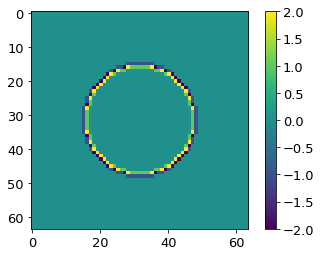

In [20]:
plt.imshow(mask_lap)
plt.colorbar()

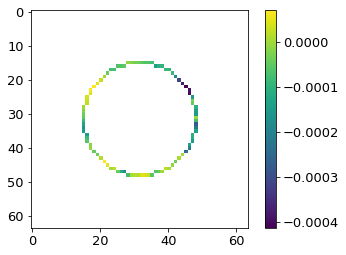

In [21]:
plt.imshow(lat_ring)
plt.colorbar()

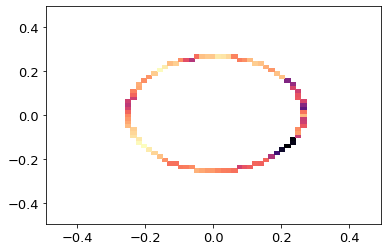

In [22]:
# plt.figure(figsize=(15,4))
# plt.subplot(131)
# plt.pcolormesh(X,Y, u[100, 8])
# plt.colorbar()
# plt.subplot(132)
# plt.pcolormesh(X,Y, v[100, 8])
# plt.colorbar()
plt.subplot()
#plt.pcolormesh(X,Y, proy)
#ring = ma.masked_array(proy, mask.mask)
plt.pcolormesh(X, Y, lat_ring, cmap='magma')
#plt.colorbar()

In [23]:
b_budget = exp.Budget('b', 0.25, 0.55)

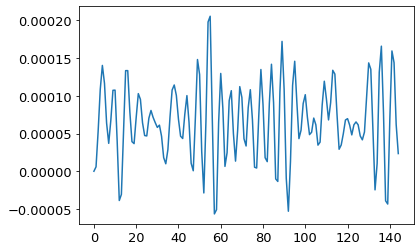

In [24]:
plt.plot(b_budget)

In [25]:
KE_budget = exp.Budget('KE', 0.25, 0.55)

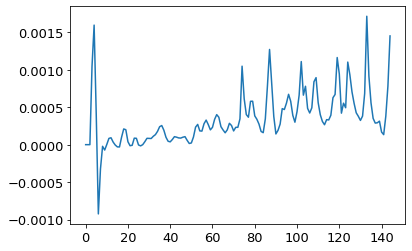

In [26]:
plt.plot(KE_budget)